#### Deep Convolutional Generative Adversarial Network

In [ ]:
from __future__ import absolute_import, division, print_function, unicode_literals

try:
  # %tensorflow_version only exists in Colab.
  %tensorflow_version 2.x
except Exception:
  pass
import tensorflow as tf

# To generate GIFs
!pip install -q imageio
import glob
import imageio
import matplotlib.pyplot as plt
import numpy as np
import os
import PIL
from tensorflow.keras import layers
from tensorflow.keras.layers import Activation

import time
import pandas as pd
from tensorflow.keras.models import load_model

plt.style.use('dark_background')

from IPython import display

In [ ]:
from google.colab import drive
drive.mount('gdrive', force_remount=True)


In [ ]:
cd gdrive/My Drive/Colab Notebooks/.../

#### Load and prepare the dataset


In [ ]:
# Data loading
data_psi = pd.read_csv("Initial_randomset_torque.csv",header=None,dtype='float32')
data_Mat = pd.read_csv("Initial_randomset_image.csv",header=None,dtype='float32')

data_psi = data_psi.values;
data_Mat = data_Mat.values;

# Normalization
data_psi = -np.log10(np.abs(data_psi)) 
data_psi = (data_psi - min(data_psi))/(max(data_psi)-min(data_psi))*10

In [ ]:
print(data_psi.shape)
print(data_Mat.shape)

(4395, 1)
(562560, 128)


In [ ]:
# Reshape data
data_psi = np.reshape(data_psi,[len(data_psi),1])
s_mat = data_Mat.shape[1]
print(len(data_Mat)/s_mat)
data_Mat = data_Mat.reshape(int(data_Mat.shape[0]/s_mat), s_mat, s_mat, 1) 
print(len(data_psi))

4395.0
4395


In [ ]:
# Loading torque predictor model
model_forward = load_model("Model_torque.h5")
model_forward.trainable = False

In [ ]:
cf = 1.0
cf = np.float32(cf)
type(cf)

numpy.float32

In [ ]:
BUFFER_SIZE = data_Mat.shape[0]
BATCH_SIZE = 8
noise_dim = 200;

In [ ]:
# Batch and shuffle the data
train_dataset = tf.data.Dataset.from_tensor_slices(data_Mat).shuffle(BUFFER_SIZE).batch(BATCH_SIZE)

#### Create the models


##### The Generator


In [ ]:
# Generator model
def make_generator_model():
    model = tf.keras.Sequential()
    model.add(layers.Dense(16*16*64, use_bias=False, input_shape=(noise_dim,)))
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())

    model.add(layers.Reshape((16, 16, 64)))
    assert model.output_shape == (None, 16, 16, 64) 

    model.add(layers.Conv2DTranspose(32, (5, 5), strides=(2, 2), padding='same', use_bias=False))
    assert model.output_shape == (None, 32, 32, 32)
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())

    model.add(layers.Conv2DTranspose(16, (5, 5), strides=(2, 2), padding='same', use_bias=False))
    assert model.output_shape == (None, 64, 64, 16)
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())

    model.add(layers.Conv2DTranspose(1, (5, 5), strides=(2, 2), padding='same', use_bias=False, activation='sigmoid'))
    assert model.output_shape == (None, 128, 128, 1)

    return model

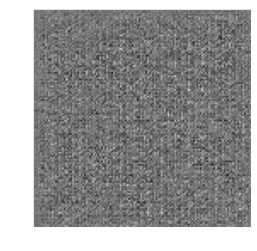

In [ ]:
# Generator image before training
generator = make_generator_model()

noise = tf.random.normal([1, noise_dim])
generated_image = generator(noise, training=False)

plt.imshow(generated_image[0, :, :, 0], cmap='gray')

##### The Discriminator


In [ ]:
def make_discriminator_model():
    model = tf.keras.Sequential()
    model.add(layers.Conv2D(16, (5, 5), strides=(2, 2), padding='same',
                                     input_shape=[128, 128, 1]))
    model.add(layers.LeakyReLU())
    model.add(layers.Dropout(0.3))

    model.add(layers.Conv2D(32, (5, 5), strides=(2, 2), padding='same'))
    model.add(layers.LeakyReLU())
    model.add(layers.Dropout(0.3))
    
    model.add(layers.Conv2D(32, (5, 5), strides=(1, 1), padding='same'))
    model.add(layers.LeakyReLU())
    model.add(layers.Dropout(0.3))


    model.add(layers.Flatten())
    model.add(layers.Dense(1))

    return model

In [ ]:
discriminator = make_discriminator_model()
decision = discriminator(generated_image)
print (decision)

tf.Tensor([[-0.10288147]], shape=(1, 1), dtype=float32)


#### Define the loss and optimizers



In [ ]:
cross_entropy = tf.keras.losses.BinaryCrossentropy(from_logits=True)

##### Discriminator loss

In [ ]:
def discriminator_loss(real_output, fake_output):
    real_loss = cross_entropy(tf.ones_like(real_output), real_output)  # we()
    fake_loss = cross_entropy(tf.zeros_like(fake_output), fake_output)
    total_loss = real_loss + fake_loss
    return total_loss

##### Generator loss


In [ ]:
def generator_loss(fake_output):
    return cross_entropy(tf.ones_like(fake_output), fake_output)

In [ ]:
@tf.custom_gradient
def round_op(x):
    result = tf.round(x)
    def round_grad(dy):
        grad = 1;
        return dy * grad
    return result, round_grad
    
class Round_L(tf.keras.layers.Layer):
    def __init__(self):
        super(Round_L, self).__init__()

    def call(self, x):
        return round_op(x)

coef_f = 0;
coef_d = 1;
coef_g = 1;

def model_forward_loss(gen_image,model_forward):
  fl = tf.reduce_mean(model_forward(round_op(gen_image)))
  return fl

In [ ]:
xtest = data_Mat[1:1001,:,:,:]
ytest = data_psi[1:1001,:]
evaluate_model = model_forward.evaluate(x=[xtest], y=ytest)
loss_metric = evaluate_model [0]
accuracy_metric = evaluate_model [1]

32/32 [==============================] - 85s 1s/step - loss: 1.9019 - mean_squared_error: 1.5499


In [ ]:
generator_optimizer = tf.keras.optimizers.Adam(1e-4)
discriminator_optimizer = tf.keras.optimizers.Adam(1e-4)


#### Save checkpoints
This notebook also demonstrates how to save and restore models, which can be helpful in case a long running training task is interrupted.

In [ ]:
checkpoint_dir = './training_checkpoints'
checkpoint_prefix = os.path.join(checkpoint_dir, "ckpt")
checkpoint = tf.train.Checkpoint(generator_optimizer=generator_optimizer,
                                 discriminator_optimizer=discriminator_optimizer,
                                 generator=generator,
                                 discriminator=discriminator)

#### Define the training loop



In [ ]:
EPOCHS = 50
num_examples_to_generate = 16
seed = tf.random.normal([num_examples_to_generate, noise_dim])

##### Define train_step()

In [ ]:

@tf.function
def train_step(images,coef_f):
    noise = tf.random.normal([BATCH_SIZE, noise_dim])

    with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:
      generated_images = generator(noise, training=True)

      real_output = discriminator(images, training=True)
      fake_output = discriminator(generated_images, training=True)

      gen_loss = generator_loss(fake_output)
      disc_loss = coef_d*discriminator_loss(real_output, fake_output)
      forw_loss = (0.32)*abs(model_forward_loss(generated_images,model_forward))*abs(model_forward_loss(generated_images,model_forward))
      total_loss = coef_g*gen_loss+coef_f*forw_loss;

    gradients_of_generator = gen_tape.gradient(total_loss, generator.trainable_variables)
    gradients_of_discriminator = disc_tape.gradient(disc_loss, discriminator.trainable_variables)
    generator_optimizer.apply_gradients(zip(gradients_of_generator, generator.trainable_variables))
    discriminator_optimizer.apply_gradients(zip(gradients_of_discriminator, discriminator.trainable_variables))
    
    return gen_loss, disc_loss, forw_loss

##### Define train()

In [ ]:
def train(dataset, epochs, coef_f):
  gen_loss_plot = np.empty(0);
  disc_loss_plot = np.empty(0);
  forw_loss_plot = np.empty(0);
  for epoch in range(epochs):
    start = time.time()
    if epoch>10:
        coef_f = 0.8/cf;
        coef_f = coef_f.astype('float32')
        if epoch>20: 
            coef_f = 1.0/cf;
            coef_f = coef_f.astype('float32')
            if epoch>30:
                coef_f = 1.4/cf;
                coef_f = coef_f.astype('float32')
    for image_batch in dataset:
      a,b,c = train_step(image_batch,coef_f)
      gen_loss_plot = np.append(gen_loss_plot,a.numpy());
      disc_loss_plot = np.append(disc_loss_plot,b.numpy());
      forw_loss_plot = np.append(forw_loss_plot,c.numpy());
    
    # Produce images for the GIF as we go
    display.clear_output(wait=True)
    ax = plt.subplot(1,3,1)
    plt.semilogy(gen_loss_plot*coef_g)
    plt.semilogy(disc_loss_plot*coef_d)
    plt.semilogy(forw_loss_plot*coef_f)
    plt.legend(['Gen_Loss','Disc_Loss','Forward_Loss'])
    ax.tick_params(axis="y", colors="blue")

    ax = plt.subplot(1,3,2)
    plt.plot(forw_loss_plot)
    plt.legend(['Forward_loss'])
    ax.tick_params(axis="y", colors="blue")

    ax = plt.subplot(1,3,3)
    plt.plot(forw_loss_plot*coef_f+gen_loss_plot*coef_g)
    plt.legend(['total_loss'])
    ax.tick_params(axis="y", colors="blue")
    plt.show()
    generate_and_save_images(generator,
                             epoch + 1,
                             seed)
    print('Time for epoch {} is {} sec'.format(epoch + 1, time.time()-start))  
       
    if (epoch + 1) % 5 == 0:
      checkpoint.save(file_prefix = checkpoint_prefix)

    print('Time for epoch {} is {} sec'.format(epoch + 1, time.time()-start))

  return gen_loss_plot, disc_loss_plot,forw_loss_plot

##### Generate and save images



In [ ]:
def generate_and_save_images(model, epoch, test_input):
  predictions = model(test_input, training=False)
  fig = plt.figure(figsize=(6,6))

  for i in range(predictions.shape[0]):
      plt.subplot(4, 4, i+1)
      plt.imshow(predictions[i, :, :, 0] * 127.5 + 127.5, cmap='gray')
      plt.axis('off')

  plt.savefig('image_at_epoch_{:04d}.png'.format(epoch))
  plt.show()

#### Train the model


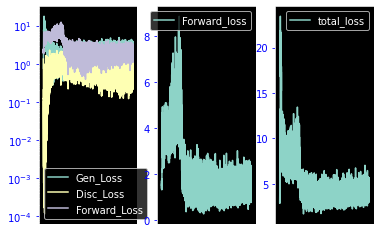

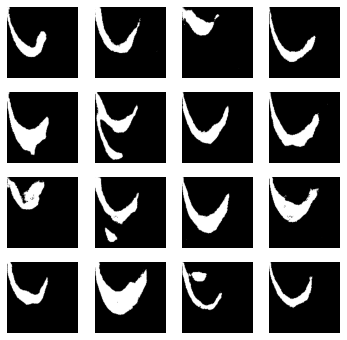

Time for epoch 50 is 703.3340721130371 sec
Time for epoch 50 is 1912.8805060386658 sec


In [ ]:
g_l,d_l,f_l = train(train_dataset, EPOCHS,coef_f);


##### Generate images 

(2000, 128, 128, 1)


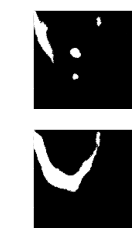

In [ ]:
nb_sol = tf.random.normal([1000, noise_dim])
pred = generator(nb_sol, training=False)
print(pred.shape)

aa= plt.subplot(2,1,1)
plt.imshow(pred[5, :, :, 0] * 255 + 255, cmap='gray')

aa= plt.subplot(2,1,2)
plt.imshow(pred[10, :, :, 0] * 127.5 + 127.5, cmap='gray')
plt.show()

##### Save images

In [ ]:
f=open('output_image_predictions_1.csv','a')

for l in range(0,len(pred)):
    np.savetxt(f,pred[l,:,:,0],fmt='%1d', delimiter=",")
  
f.close()

##### Save loss functions

In [ ]:
ans_batch = 1;
np.savetxt('output_forwloss{:02d}_1.csv'.format(ans_batch),f_l)
np.savetxt('output_genloss{:02d}_1.csv'.format(ans_batch),g_l)
np.savetxt('output_discloss{:02d}_1.csv'.format(ans_batch),d_l)

##### Save the generator model

In [ ]:
#generator model save
generator.compile()
generator.save('nanomotor_generator')

INFO:tensorflow:Assets written to: nanomotor_generator/assets


##### Restore the latest checkpoint.

In [ ]:
checkpoint.restore(tf.train.latest_checkpoint(checkpoint_dir))

#### Create a GIF


In [ ]:
# Display a single image using the epoch number
def display_image(epoch_no):
  return PIL.Image.open('image_at_epoch_{:04d}.png'.format(epoch_no))

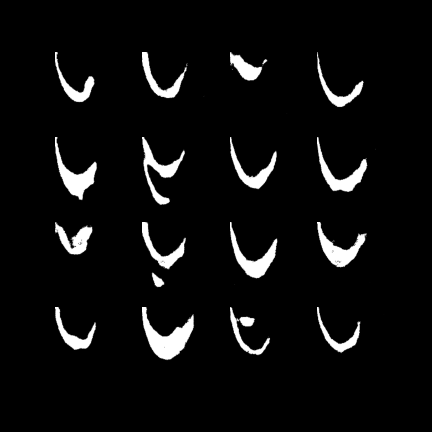

In [ ]:
display_image(EPOCHS)